In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import time
import os

print("CUDA hazır mı?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name())


CUDA hazır mı? True
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:

data_path = r"C:\Users\Lenovo\Desktop\dlp\garbage-dataset"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(data_path, transform=transform)
print("Toplam Görsel Sayısı:", len(dataset))
print("Sınıflar:", dataset.classes)

train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print("Train:", len(train_set), "Val:", len(val_set), "Test:", len(test_set))


Toplam Görsel Sayısı: 19762
Sınıflar: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Train: 15809 Val: 1976 Test: 1977


In [3]:

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=10).to(device)

print("Model başarıyla oluşturuldu. Cihaz:", device)


Model başarıyla oluşturuldu. Cihaz: cuda


In [4]:
import math
import random

def random_search_lr(model, train_loader, val_loader, device, trials=5, random_epochs=5):

    lr_candidates = [10 ** random.uniform(-5, -2) for _ in range(trials)]
    print("Aday Öğrenme Oranları:", lr_candidates)

    criterion = nn.CrossEntropyLoss()

    best_lr = None
    best_val_acc = 0.0

    for lr in lr_candidates:
        print(f"\nDeneme LR = {lr}")

        temp_model = SimpleCNN(num_classes=10).to(device)
        optimizer = optim.Adam(temp_model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=random_epochs)

        best_temp_acc = 0
        patience = 3
        wait = 0

        for epoch in range(random_epochs):
            temp_model.train()
            train_correct = 0
            total = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = temp_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                train_correct += (preds == labels).sum().item()
                total += labels.size(0)

            scheduler.step()
            train_acc = train_correct / total

            temp_model.eval()
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = temp_model(images)
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)

            val_acc = val_correct / val_total
            print(f"Epoch {epoch+1}/{random_epochs} | Val Acc = {val_acc:.4f}")

            if val_acc > best_temp_acc:
                best_temp_acc = val_acc
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print("Early Stopping!")
                    break

        if best_temp_acc > best_val_acc:
            best_val_acc = best_temp_acc
            best_lr = lr

    print("\nEn iyi öğrenme oranı:", best_lr)
    return best_lr


best_lr = random_search_lr(model, train_loader, val_loader, device)
best_lr


Aday Öğrenme Oranları: [0.0006277525994492614, 0.006493165939295753, 0.000606953131434196, 0.002582586501332054, 0.0019689595798894474]

Deneme LR = 0.0006277525994492614
Epoch 1/5 | Val Acc = 0.5577
Epoch 2/5 | Val Acc = 0.6599
Epoch 3/5 | Val Acc = 0.7045
Epoch 4/5 | Val Acc = 0.7257
Epoch 5/5 | Val Acc = 0.7328

Deneme LR = 0.006493165939295753
Epoch 1/5 | Val Acc = 0.3497
Epoch 2/5 | Val Acc = 0.4696
Epoch 3/5 | Val Acc = 0.5668
Epoch 4/5 | Val Acc = 0.6027
Epoch 5/5 | Val Acc = 0.6331

Deneme LR = 0.000606953131434196
Epoch 1/5 | Val Acc = 0.5496
Epoch 2/5 | Val Acc = 0.6377
Epoch 3/5 | Val Acc = 0.6523
Epoch 4/5 | Val Acc = 0.6908
Epoch 5/5 | Val Acc = 0.7176

Deneme LR = 0.002582586501332054
Epoch 1/5 | Val Acc = 0.5319
Epoch 2/5 | Val Acc = 0.6093
Epoch 3/5 | Val Acc = 0.6564
Epoch 4/5 | Val Acc = 0.6938
Epoch 5/5 | Val Acc = 0.7141

Deneme LR = 0.0019689595798894474
Epoch 1/5 | Val Acc = 0.5405
Epoch 2/5 | Val Acc = 0.6129
Epoch 3/5 | Val Acc = 0.6538
Epoch 4/5 | Val Acc = 0.6

0.0006277525994492614

In [5]:
best_lr = 0.00305859764314748 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

train_losses = []
val_losses = []
train_accs = []
val_accs = []
lrs = []

best_val_acc = 0.0

for epoch in range(20): 
    print(f"\n=== Epoch {epoch+1} / 20 ===")

    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    lrs.append(optimizer.param_groups[0]["lr"])

    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_final_model.pth")
        print(">> En iyi model kaydedildi!")

print("\nEğitim tamamlandı!")




=== Epoch 1 / 20 ===
Train Loss: 1.5837 | Train Acc: 0.4491
Val Loss:   1.6975 | Val Acc:   0.4413
LR: 0.0030397694369280067
>> En iyi model kaydedildi!

=== Epoch 2 / 20 ===
Train Loss: 1.2766 | Train Acc: 0.5603
Val Loss:   1.7113 | Val Acc:   0.3973
LR: 0.0029837484311939447

=== Epoch 3 / 20 ===
Train Loss: 1.1306 | Train Acc: 0.6159
Val Loss:   1.1987 | Val Acc:   0.5946
LR: 0.002891914049029525
>> En iyi model kaydedildi!

=== Epoch 4 / 20 ===
Train Loss: 0.9462 | Train Acc: 0.6764
Val Loss:   1.1204 | Val Acc:   0.6285
LR: 0.0027665275577044763
>> En iyi model kaydedildi!

=== Epoch 5 / 20 ===
Train Loss: 0.7443 | Train Acc: 0.7488
Val Loss:   1.1348 | Val Acc:   0.6538
LR: 0.0026106763887691277
>> En iyi model kaydedildi!

=== Epoch 6 / 20 ===
Train Loss: 0.5591 | Train Acc: 0.8099
Val Loss:   1.2675 | Val Acc:   0.6306
LR: 0.002428198115243043

=== Epoch 7 / 20 ===
Train Loss: 0.4090 | Train Acc: 0.8592
Val Loss:   1.3603 | Val Acc:   0.6594
LR: 0.0022235859578311023
>> En iy

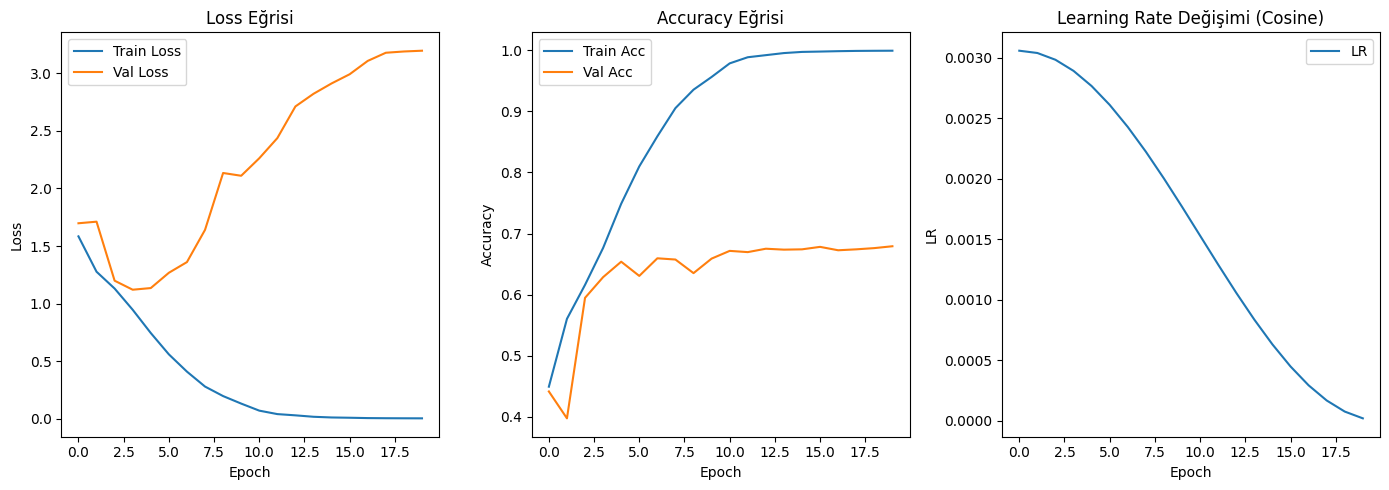

In [6]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Eğrisi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Eğrisi")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(lrs, label="LR")
plt.title("Learning Rate Değişimi (Cosine)")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
best_model = SimpleCNN().to(device)

best_weights = torch.load("best_final_model.pth", weights_only=True)
best_model.load_state_dict(best_weights)

best_model.eval()

all_labels = []
all_preds = []
all_preds_prob = []

class_names = dataset.classes  

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        outputs = best_model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_preds_prob.extend(probs.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_pred_prob = np.array(all_preds_prob)

print("Test tahminleri başarıyla alındı!")
print("Sınıflar:", class_names)
print("Örnek sayısı:", len(y_true))



Test tahminleri başarıyla alındı!
Sınıflar: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Örnek sayısı: 1977


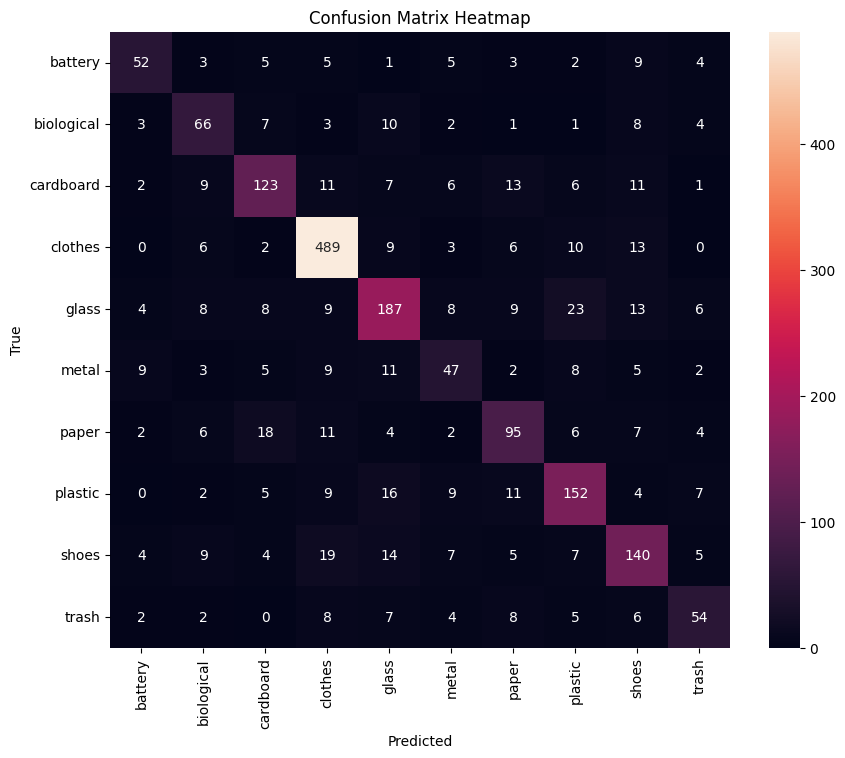

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


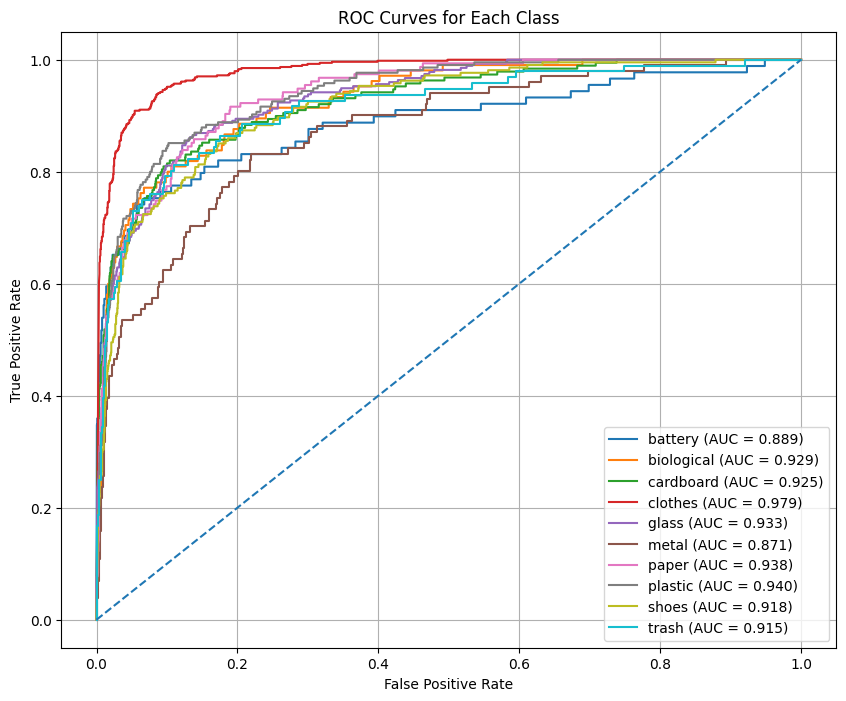

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

n_classes = len(class_names)

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")

plt.title("ROC Curves for Each Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


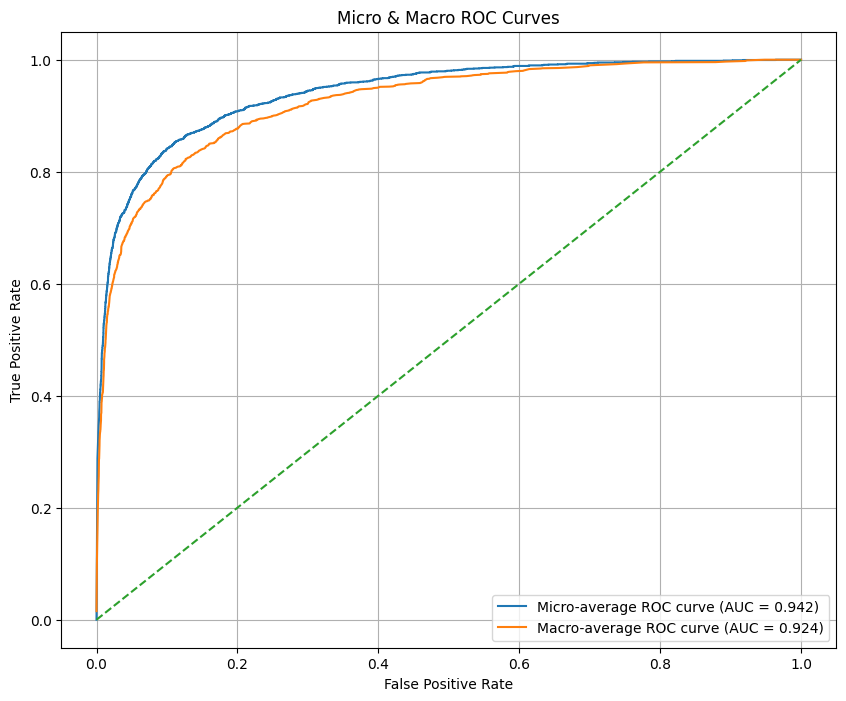

In [15]:
from sklearn.metrics import roc_curve, auc

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

fpr_macro = dict()
tpr_macro = dict()
roc_auc_macro = dict()

for i in range(n_classes):
    fpr_macro[i], tpr_macro[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])

all_fpr = np.unique(np.concatenate([fpr_macro[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_macro[i], tpr_macro[i])

mean_tpr /= n_classes

roc_auc_macro = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro,
         label=f"Micro-average ROC curve (AUC = {roc_auc_micro:.3f})")
plt.plot(all_fpr, mean_tpr,
         label=f"Macro-average ROC curve (AUC = {roc_auc_macro:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")

plt.title("Micro & Macro ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


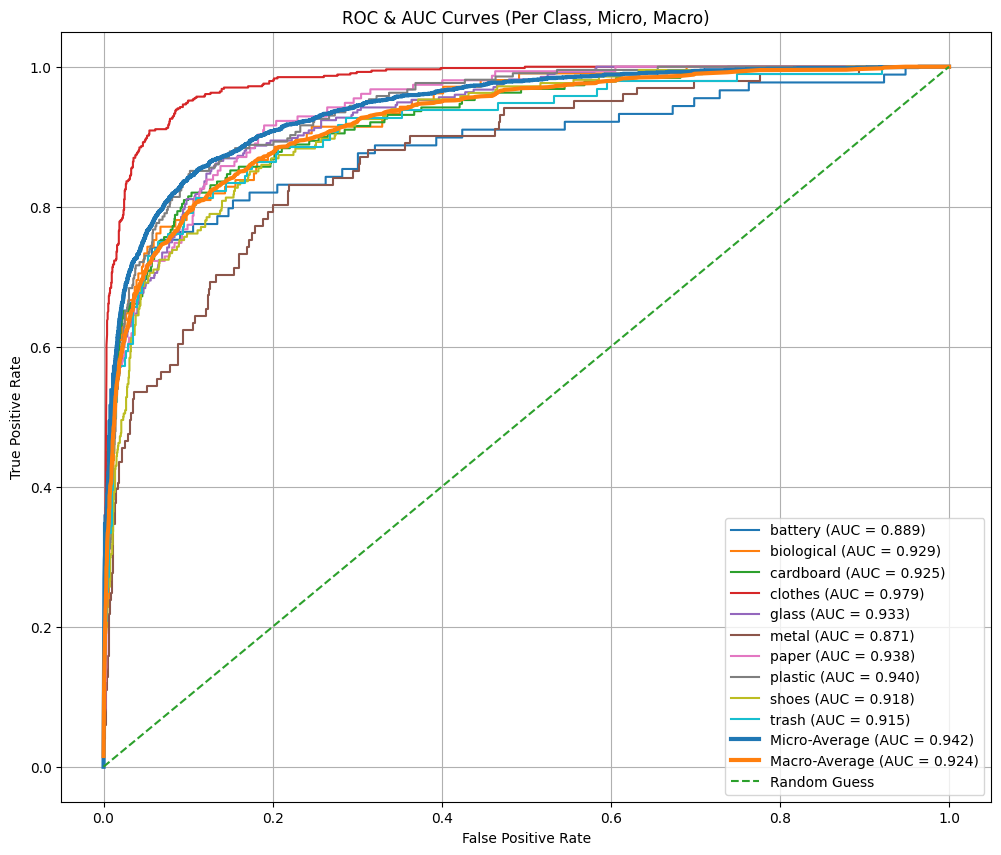

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

plt.figure(figsize=(12, 10))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(
    fpr_micro, tpr_micro,
    label=f"Micro-Average (AUC = {roc_auc_micro:.3f})",
    linewidth=3
)

all_fpr = np.unique(np.concatenate([
    roc_curve(y_true_bin[:, i], y_pred_prob[:, i])[0]
    for i in range(n_classes)
]))

mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)

mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

plt.plot(
    all_fpr, mean_tpr,
    label=f"Macro-Average (AUC = {roc_auc_macro:.3f})",
    linewidth=3
)

plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")

plt.title("ROC & AUC Curves (Per Class, Micro, Macro)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()


In [10]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix hazır!")
print(cm)


Confusion Matrix hazır!
[[ 52   3   5   5   1   5   3   2   9   4]
 [  3  66   7   3  10   2   1   1   8   4]
 [  2   9 123  11   7   6  13   6  11   1]
 [  0   6   2 489   9   3   6  10  13   0]
 [  4   8   8   9 187   8   9  23  13   6]
 [  9   3   5   9  11  47   2   8   5   2]
 [  2   6  18  11   4   2  95   6   7   4]
 [  0   2   5   9  16   9  11 152   4   7]
 [  4   9   4  19  14   7   5   7 140   5]
 [  2   2   0   8   7   4   8   5   6  54]]


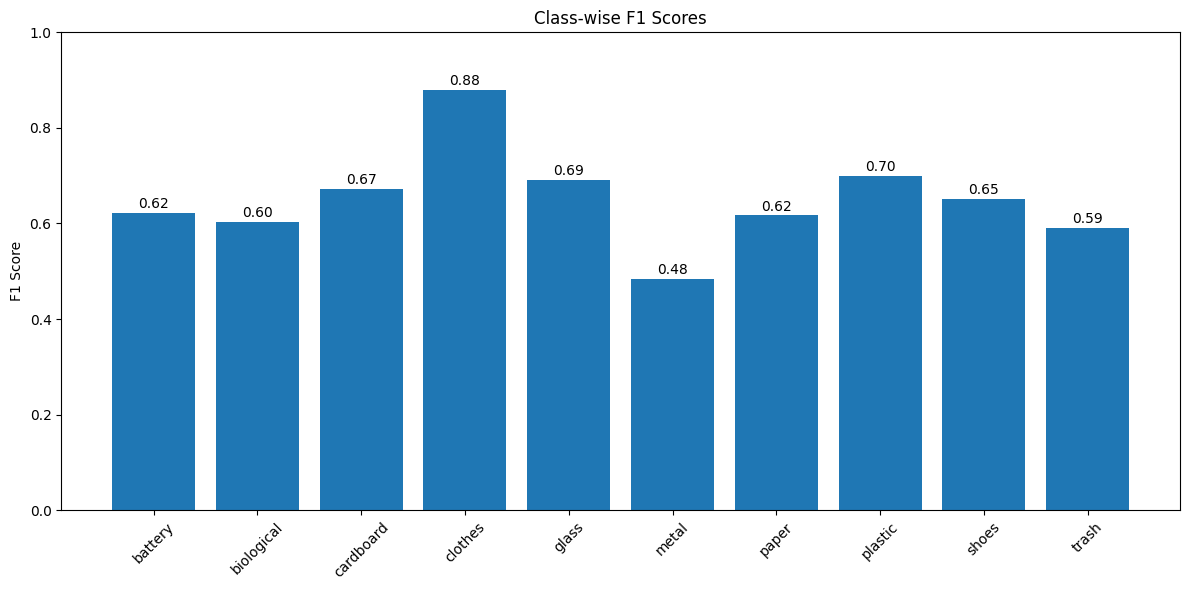

In [17]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

f1_scores = f1_score(y_true, y_pred, average=None)

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, f1_scores)

for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', fontsize=10)

plt.title("Class-wise F1 Scores")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



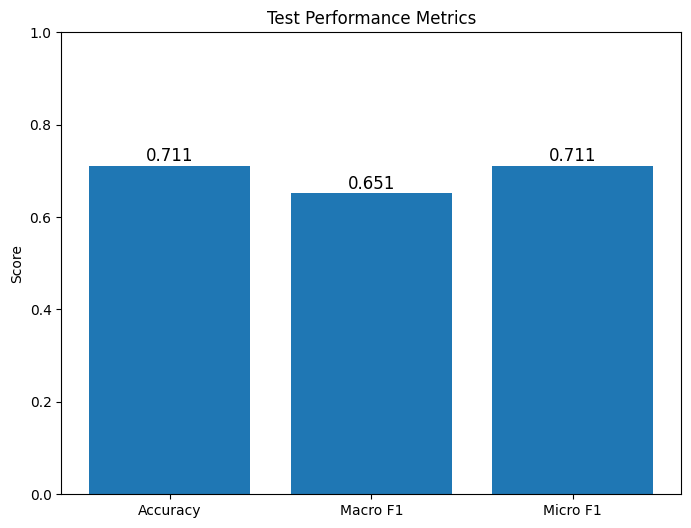

In [18]:
test_accuracy = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
micro_f1 = f1_score(y_true, y_pred, average="micro")

metrics = ["Accuracy", "Macro F1", "Micro F1"]
values = [test_accuracy, macro_f1, micro_f1]

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values)

for bar, score in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.3f}", ha='center', fontsize=12)

plt.ylim(0, 1)
plt.title("Test Performance Metrics")
plt.ylabel("Score")
plt.show()


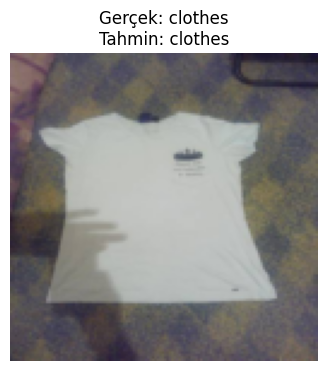

Gerçek sınıf : clothes
Tahmin edilen : clothes


In [19]:
import random
import matplotlib.pyplot as plt

idx = random.randint(0, len(test_set) - 1)

image, label = test_set[idx]
true_label = class_names[label]

model.eval()
with torch.no_grad():
    img_tensor = image.unsqueeze(0).to(device)
    output = model(img_tensor)
    _, pred = torch.max(output, 1)
    pred_label = class_names[pred.item()]

plt.figure(figsize=(4, 4))
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}", fontsize=12)
plt.show()

print("Gerçek sınıf :", true_label)
print("Tahmin edilen :", pred_label)



In [20]:
import matplotlib.pyplot as plt
import random
import torch

def show_random_test_images(model, test_loader, device, class_names, num_images=5):
    model.eval()
    images_shown = 0

    all_images = []
    all_labels = []

    for imgs, lbls in test_loader:
        for i in range(len(imgs)):
            all_images.append(imgs[i])
            all_labels.append(lbls[i])

    print(f"Toplam test görüntüsü: {len(all_images)}")

    indices = random.sample(range(len(all_images)), num_images)

    with torch.no_grad():
        for idx in indices:
            img = all_images[idx].unsqueeze(0).to(device)
            true_label = class_names[all_labels[idx].item()]

            output = model(img)
            pred_idx = torch.argmax(output, dim=1).item()
            pred_label = class_names[pred_idx]

            img_np = all_images[idx].permute(1, 2, 0).cpu().numpy()

            plt.figure(figsize=(4, 4))
            plt.imshow(img_np)
            plt.axis("off")
            plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}", fontsize=12)
            plt.show()

            print(f"Gerçek sınıf: {true_label} | Tahmin: {pred_label}")
            print("-" * 40)


Toplam test görüntüsü: 1977


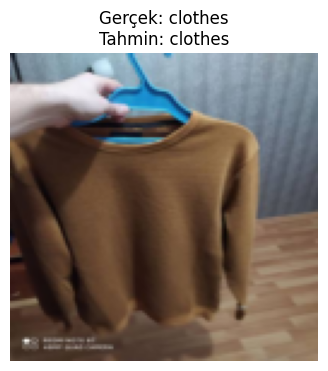

Gerçek sınıf: clothes | Tahmin: clothes
----------------------------------------


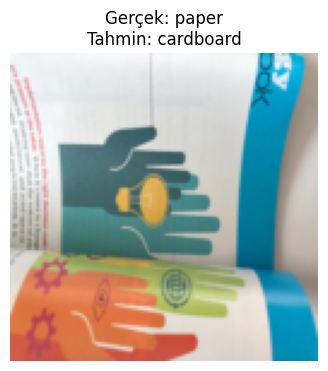

Gerçek sınıf: paper | Tahmin: cardboard
----------------------------------------


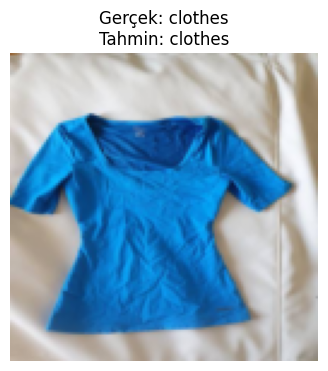

Gerçek sınıf: clothes | Tahmin: clothes
----------------------------------------


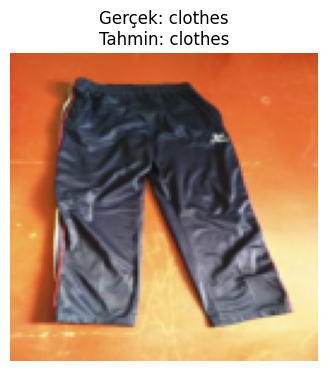

Gerçek sınıf: clothes | Tahmin: clothes
----------------------------------------


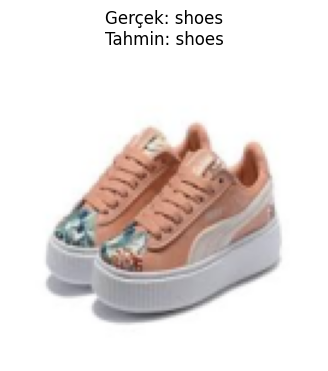

Gerçek sınıf: shoes | Tahmin: shoes
----------------------------------------


In [21]:
show_random_test_images(model, test_loader, device, class_names, num_images=5)


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

def show_random_test_images(model, test_loader, device, class_names, num_images=4):
    model.eval()
    
    images_list = []
    labels_list = []

    for images, labels in test_loader:
        for i in range(images.size(0)):
            images_list.append(images[i])
            labels_list.append(labels[i].item())

    idxs = random.sample(range(len(images_list)), num_images)

    plt.figure(figsize=(18, 4))

    for i, idx in enumerate(idxs):

        img = images_list[idx].unsqueeze(0).to(device)
        true_label = class_names[labels_list[idx]]

        with torch.no_grad():
            output = model(img)
            _, pred = torch.max(output, 1)
            predicted_label = class_names[pred.item()]

        img_np = images_list[idx].permute(1, 2, 0).numpy()

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"Gerçek: {true_label}\nTahmin: {predicted_label}")

    plt.tight_layout()
    plt.show()

print("Fonksiyon yüklendi: show_random_test_images()")


Fonksiyon yüklendi: show_random_test_images()


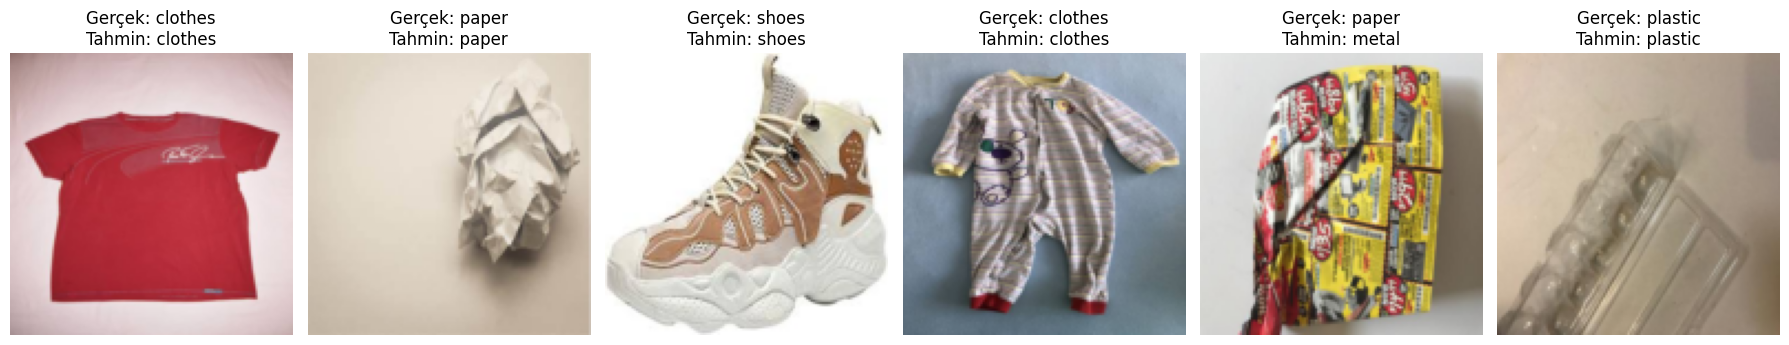

In [23]:
show_random_test_images(model, test_loader, device, class_names, num_images=6)


In [24]:
import time
import torch

model.eval() 

start_time = time.time()

with torch.no_grad():  # hesaplama güvenli
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _ = torch.argmax(outputs, dim=1)

end_time = time.time()

epoch_time = end_time - start_time
total_time = epoch_time * 20  

print(f"1 Epoch Tahmini Süre: {epoch_time:.2f} saniye")
print(f"20 Epoch Toplam Tahmini Eğitim Süresi: {total_time/60:.2f} dakika")


1 Epoch Tahmini Süre: 119.48 saniye
20 Epoch Toplam Tahmini Eğitim Süresi: 39.83 dakika


In [25]:
y_true = []
y_pred = []
y_pred_prob = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_prob.extend(probs.cpu().numpy())

print("Tahminler yenilendi.")
print("Toplam örnek:", len(y_true))


Tahminler yenilendi.
Toplam örnek: 1977


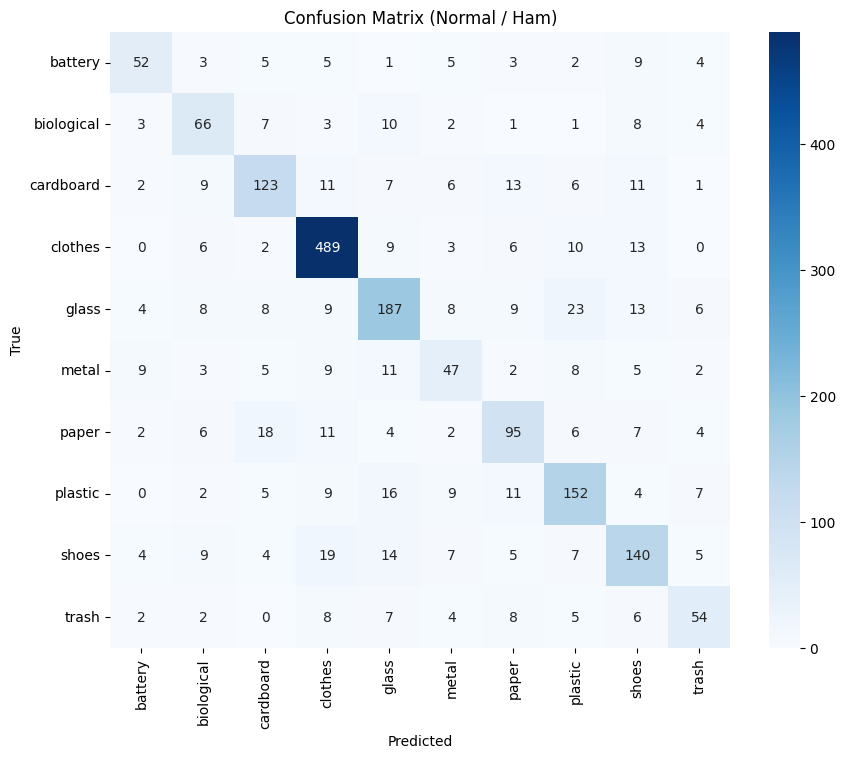

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix (Normal / Ham)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


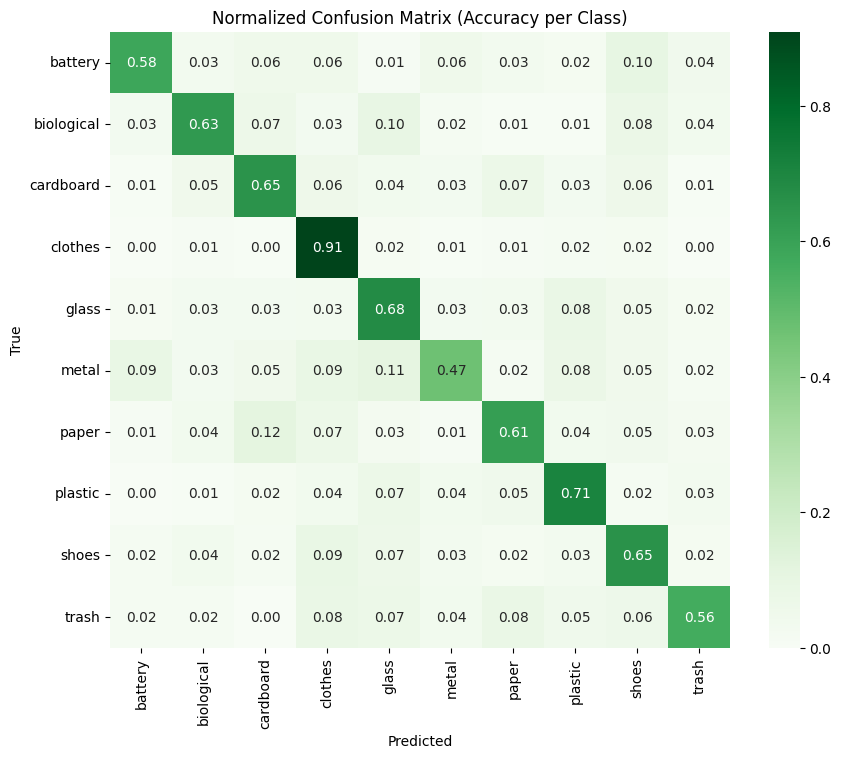

In [27]:
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Normalized Confusion Matrix (Accuracy per Class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
